In [1]:
%load_ext autoreload
%autoreload 2

from other_utils import np_utils, sk_utils
import numpy as np
import tensorflow as tf
import os
import numpy as np
import tensorflow as tf
#import imageio
from termcolor import colored
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import matplotlib.gridspec as gridspec


import model 
from hyperparams import Hyperparameters
import graph 
from data_loader import Data_loader
import model_componets as comps


# from pose import model as PM

utils.py:41: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/data/vcl/sid/rahul/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/data/vcl/sid/rahul/local/lib/python2.7/site-pac

In [2]:
H = Hyperparameters ()

D = Data_loader(H.data_path,H.seq_length,H.batch_size)


os.environ['CUDA_VISIBLE_DEVICES'] = str(2)

config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)




input_ph = tf.placeholder(tf.float32, shape= [None , H.num_joints ,3],name = 'skeleton_input')

global_step = tf.train.get_or_create_global_step()

x_input = input_ph

x_input_view_norm,x_input_local,tr_mats = comps.root_relative_to_local(x_input)

encoder_out = graph.apply_pose_encoder(input_ph)

pose_encoder_params = graph.get_network_params("Encoder_net")

# encoder_input = tf.reshape(encoder_out,(-1,H.seq_length,32))

# encoder_lstm_out = model.apply_encoder(encoder_input,name ='motion_encoder')

# z_state = encoder_lstm_out['z_state']

# z_outputs = encoder_lstm_out['z_outputs']



# decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

# motion_recon = decoder_lstm_out['x_recon']

# motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

pose_recon = graph.apply_pose_decoder(encoder_out)#view norm

pose_decoder_params = graph.get_network_params("Decoder_net")





# param_lstm_encoder = model.get_network_params('motion_encoder')

# param_lstm_decoder = model.get_network_params('motion_decoder')




sess.run(tf.global_variables_initializer())

print colored("loading weights","blue")


#enc_wt = '../../../../17j/codes_2020/pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/encoder_iter-894001'
#dec_wt = '../../../../17j/codes_2020/pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/decoder_iter-894001'

#tf.train.Saver(pose_encoder_params).restore(sess,enc_wt) 
#print colored("loaded pose_encoder weights","yellow")

#tf.train.Saver(pose_decoder_params).restore(sess,dec_wt)
#print colored("loaded pose_decoder weights","blue")



tf.train.Saver(pose_encoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001') 
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

# tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_encoder/'))
# print colored("loaded pose lstm_encoder weights","green")

# tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_decoder/'))
# print colored("laoded pose lstm_decoder weights","red")

OSError: [Errno 2] No such file or directory: '../../../data/data_15j/'

In [62]:
train_batch = np.array(D.get_sequence_batch_train())

print(train_batch.shape)
train_batch = train_batch[:,0:30]

# train_batch = np.reshape(utils.augment_pose_seq(train_batch),(-1,H.num_joints * 3))

train_batch = train_batch.reshape((-1,H.num_joints,3))


# print train_batch.reshape(-1,H.seq_length,H.num_joints,3).shape

('SHAPE: ', (30, 15, 3))
(3, 30, 45)


In [63]:
# pred_ops = dms.predict(x_batch)
# predictions = pred_ops
# predictions.shape

feed_dict = {x_input : train_batch}

pred_ops = sess.run(encoder_out,feed_dict=feed_dict)
predictions = pred_ops

predictions.shape


(90, 32)

In [64]:
mean = np.mean(predictions, axis=0)
std = np.std(predictions,axis=0)

print mean.shape
print std.shape

# x_pred = dms.decode(predictions)
# x_pred.shape

# imgs = sk_utils.get_skeleton_images(x_pred[0], title_prefix='p')
# len(imgs)
print('minimum vaue of mean ', min(mean))
print('minimum value of std ', min(std))
print('maximum value of mean', max(mean))
print('maximum value of std', max(std))


(32,)
(32,)
('minimum vaue of mean ', -0.6467105)
('minimum value of std ', 0.019045893)
('maximum value of mean', 0.6257057)
('maximum value of std', 0.18150395)


In [65]:
sample_1 = mean+(1*std)
sample_2 = mean-(1*std)
sample_1 = np.reshape(sample_1 , (1,32))
sample_2 = np.reshape(sample_2 , (1,32))
map_d = 10


In [66]:
a = np.linspace(0,1, map_d)
a = np.reshape(a, (map_d,1))
a.shape

(10, 1)

In [67]:
vertical = a*sample_1[:,:16] + (1-a)*sample_2[:,:16]

assert (vertical[0] == sample_2[0,:16]).all()


print vertical.shape

(10, 16)


In [68]:
horizontal = a*sample_1[:,16:] + (1-a)*sample_2[:,16:]

assert (horizontal[0] == sample_2[0,16:]).all()

print horizontal.shape

(10, 16)


In [69]:
grid = np.empty((map_d,map_d,32))

In [70]:
for i in range(map_d):
    for j in range(map_d):
        grid[i,j] = np.concatenate((vertical[i], horizontal[j]))

In [71]:
grid_flat = np.reshape(grid, (-1,32))

print grid.shape
print grid_flat.shape

(10, 10, 32)
(100, 32)


In [72]:

state_ph = tf.placeholder(tf.float32,shape = [None,32],name = "lstm_state")

def decoder(z_state):
#     decoder_lstm_out = model.apply_decoder(z_state,z_outputs,name = 'motion_decoder')

#     motion_recon = decoder_lstm_out['x_recon']

#     motion_recon_reshaped = tf.reshape(motion_recon,((-1,32)))

#     pose_recon = graph.apply_pose_decoder(motion_recon_reshaped)#view norm

#     pose_decoder_params = graph.get_network_params("Decoder_net")
    
    pose_recon = graph.apply_pose_decoder(z_state)#view norm

    pose_decoder_params = graph.get_network_params("Decoder_net")
    
    return pose_recon
    
print colored("loading weights","blue")

#enc_wt = '../../../../17j/codes_2020/pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/encoder_iter-894001'
#dec_wt = '../../../../17j/codes_2020/pose_embedding_training_full_norm_range_one_vneck/pretrained_weights/decoder_iter-894001'

#tf.train.Saver(pose_encoder_params).restore(sess,enc_wt) 
#print colored("loaded pose_encoder weights","yellow")

#tf.train.Saver(pose_decoder_params).restore(sess,dec_wt)
#print colored("loaded pose_decoder weights","blue")


tf.train.Saver(pose_encoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/encoder_iter-799001') 
print colored("loaded pose_encoder weights","yellow")

tf.train.Saver(pose_decoder_params).restore(sess,'../../../pose_embedding_train_full_view_norm_range_one/ent44_15j_32/weights/decoder_iter-799001')
print colored("loaded pose_decoder weights","blue")

# tf.train.Saver(param_lstm_encoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_encoder/'))
# print colored("loaded pose lstm_encoder weights","green")

# tf.train.Saver(param_lstm_decoder).restore(sess,tf.train.latest_checkpoint('../../../motion_embedding_train/ent_44_15j_32/BILSTM_TRAIN/weights/lstm_decoder/'))
# print colored("laoded pose lstm_decoder weights","red")
 
pred_ops_ph = decoder(state_ph)

pred_ops = sess.run(pred_ops_ph,feed_dict={state_ph : grid_flat})
    
# predictions = pred_ops.reshape(-1,H.seq_length,H.num_joints,3)
pred_ops.shape

loading weights
loaded pose_encoder weights
loaded pose_decoder weights


(100, 15, 3)

In [73]:
# predictions = np.mean(predictions, axis=-1)
# predictions = np.mean(predictions, axis=-1)

# print predictions.shape

# square_shaped = pred_ops.reshape((10,10,15,3))
# print square_shaped.shape

In [74]:
limb_parents = [0, 0, 1, 2, 3, 1, 5, 6, 1, 0, 9, 10, 0, 12, 13]


def get_ax(joints_3d, fig, az=0, ele=10, subplot='111'):
    x, y, z = subplot
    ax = fig.add_subplot(subplot, projection='3d')

    lim = np.max(np.abs(joints_3d))
    ax.view_init(azim=az, elev=ele)

    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    return ax

def plot_skeleton(ax, ske,color_ours,az, ground_size=0.5):
        lcolor = color_ours[0]
        rcolor = color_ours[1]
        ax.grid(False)
#         # Hide axes ticks
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_zticks([])
#         plt.axis('off')
#         ax.set_aspect('equal')
        ax.elev = 10
        ax.azim = az
#         ax.azim = 0 
#         ax.dist = 9
#         ax.set_xlim(-10, 10)
#         ax.set_ylim(-10, 10)
#         ax.set_zlim(-10, 10)
        
        

        lim = np.max(np.abs(ske))
#         ax.view_init(azim=az, elev=ele)

        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_zlim(-lim, lim)
        
        ax.set_xlabel('x',labelpad=-8)
        ax.set_ylabel('y',labelpad=-8)
        ax.set_zlabel('z',labelpad = -10)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        ax.axis('off')       




        # ax.set_aspect('equal')

#         ax.view_init(azim=90, elev=10)

        C = [{0: lcolor,  1: rcolor}[flag] for flag in lr_flags]
        P = limb_parents

        # Make connection matrix
#         joint_lines = []
        for i in range(ske.shape[0]):
            x = [ske[i, 0], ske[P[i], 0]]
            y = [ske[i, 1], ske[P[i], 1]]
            z = [ske[i, 2], ske[P[i], 2]]
#             x = [ske[i, 0]*1.2, ske[P[i]*1.2, 0]]
#             y = [ske[i, 1]*1.2, ske[P[i]*1.2, 1]]
#             z = [ske[i, 2]*1.2, ske[P[i]*1.2, 2]]
            
            # print x,y,z
            ax.plot(x, y, z, lw=4, c=C[i])



# color_ours = ['blue',  'green']
# color_ours = ['#5879ff',  '#cc2520']

lr_flags = [
    1, 1,
    1, 1, 1,
    0, 0, 0,
    1,
    1, 1, 1, 1,
    0, 0, 0, 0,
]




def get_all_plots_images(skeleton_strips):
    m = 15
    fig=plt.figure(figsize=(1.77 * 4 * 15 , 4))
    gs = gridspec.GridSpec(1, m)
    gs.update(wspace=0.05, hspace=0.4, left = None, right = 0.6, bottom = 0.1, top = 0.9) 

    for j in range(m):
        idx = j
        ax = plt.subplot(gs[idx])
        k=mpimg.imread(skeleton_strips[j])
        ax.imshow(k)
        ax.axis('off')       

    return fig  


def get_all_plots(skeleton_strips_male,az):
    fig=plt.figure(figsize=(4  * 15 , 4))
    gs = gridspec.GridSpec(1, 10)
#     gs.update(wspace=0.05, hspace=0.0005) # set the spacing between axes. 
    gs.update(wspace=0.05, hspace=0.4, left = None, right = 0.6, bottom = 0.1, top = 0.9) 

#     lcolor, rcolor = colors
    for j in range(10):
        idx = j
        ax = plt.subplot(gs[idx], projection='3d')
#         color_ours = ['blue',  'green']
        color_ours = ['k','m']

        plot_skeleton(ax, skeleton_strips_male[j],color_ours,az)
#         color_ours = ['#5879ff',  '#cc2520']
#         color_ours = ['k','m']
#         plot_skeleton(ax, skeleton_strips_female[j],color_ours)
        
    return fig


0
1
2
3
4
5
6
7
8
9
(100, 15, 3)


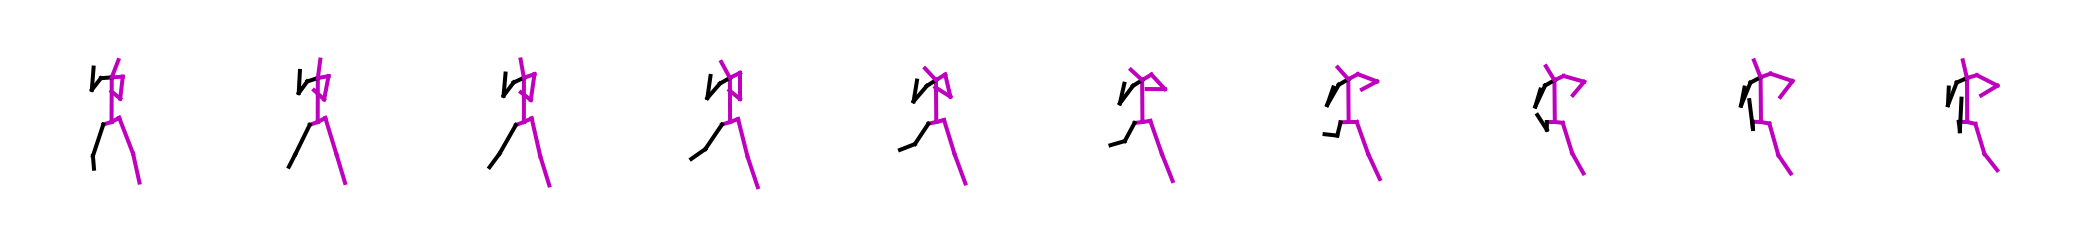

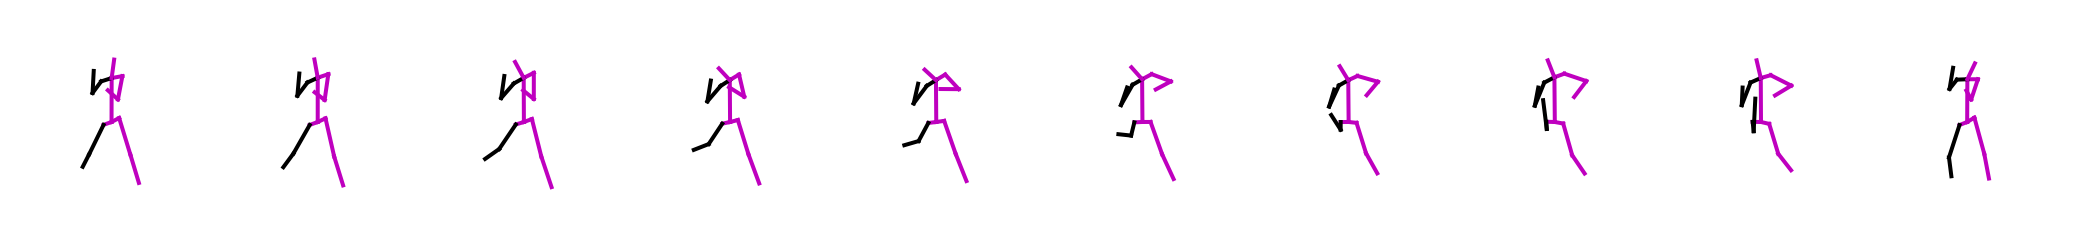

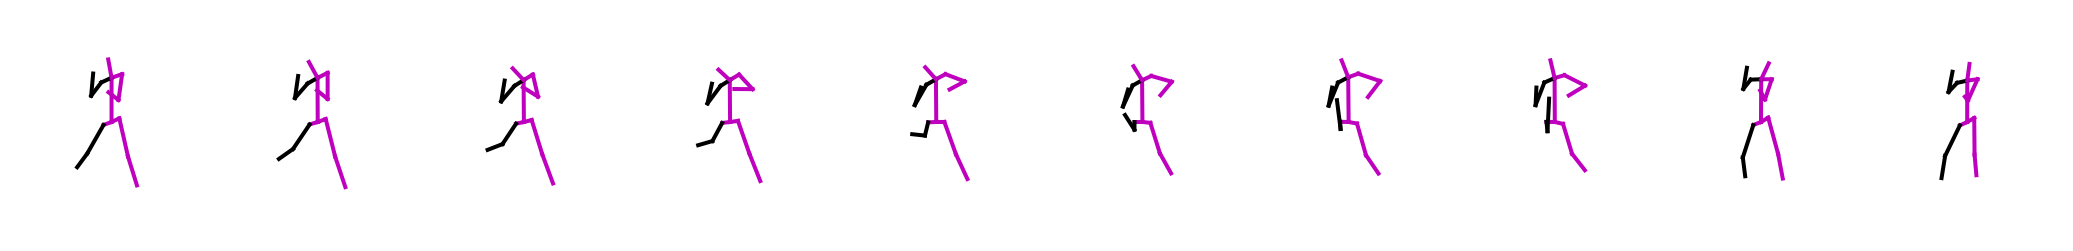

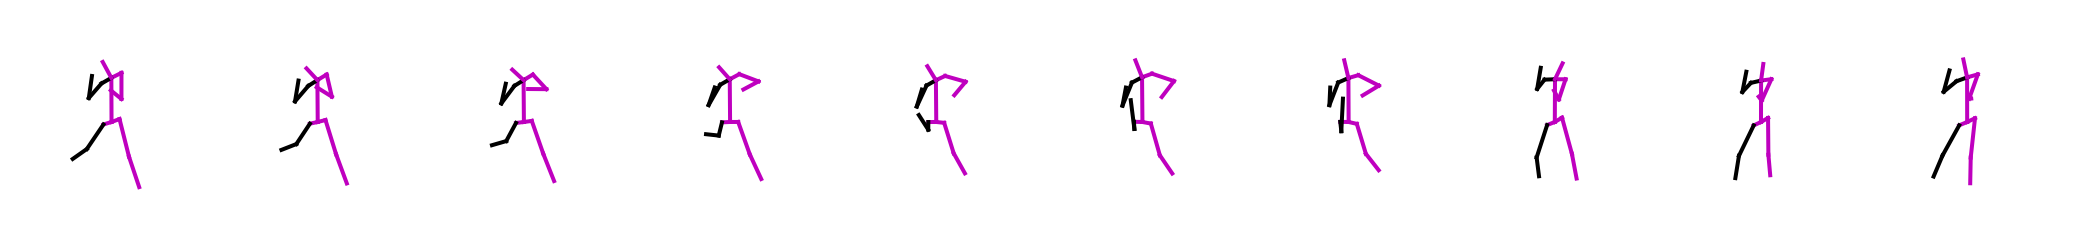

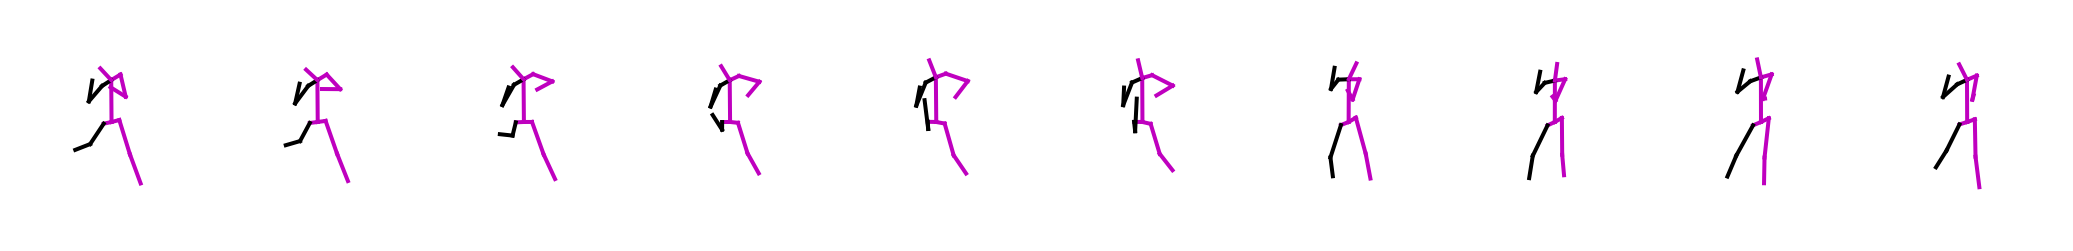

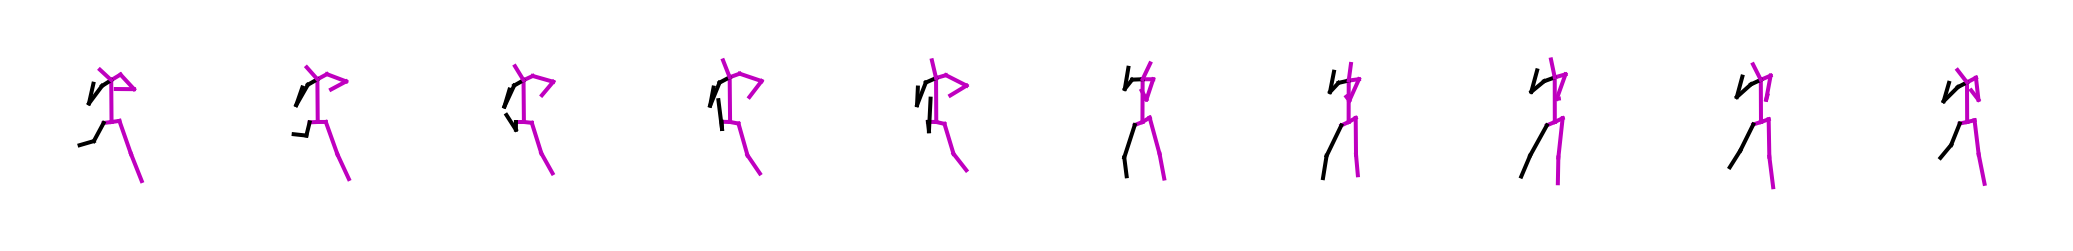

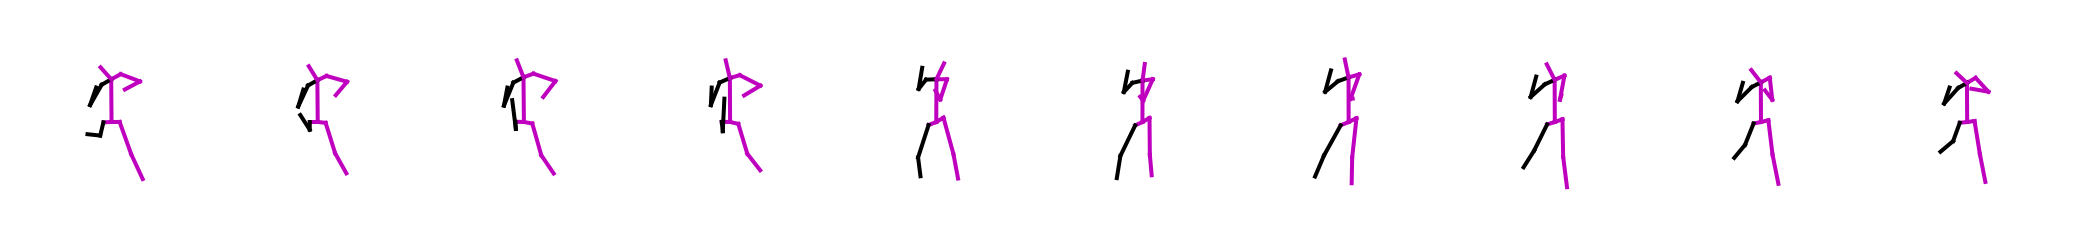

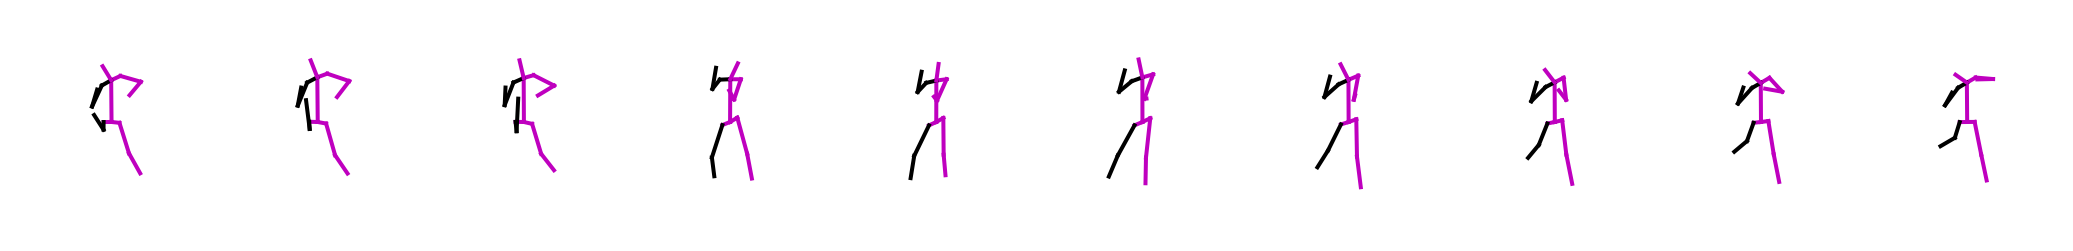

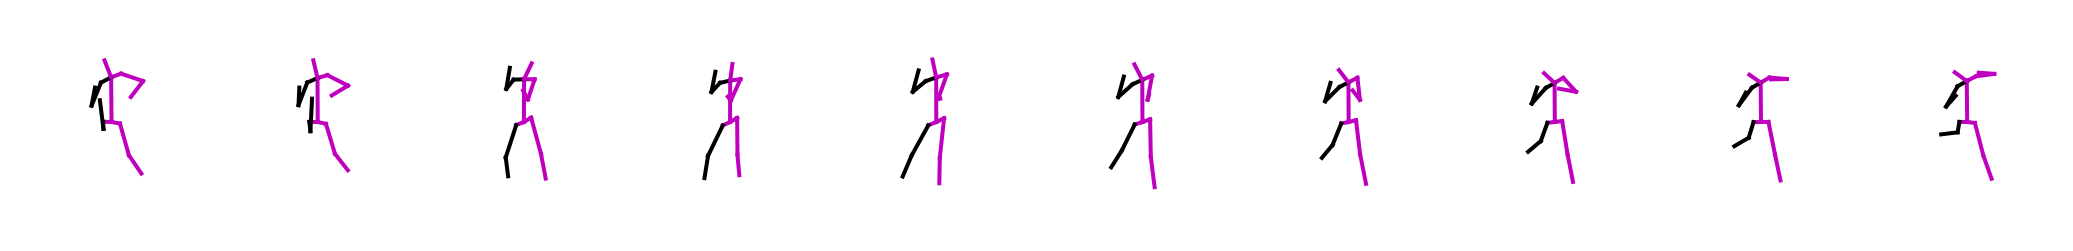

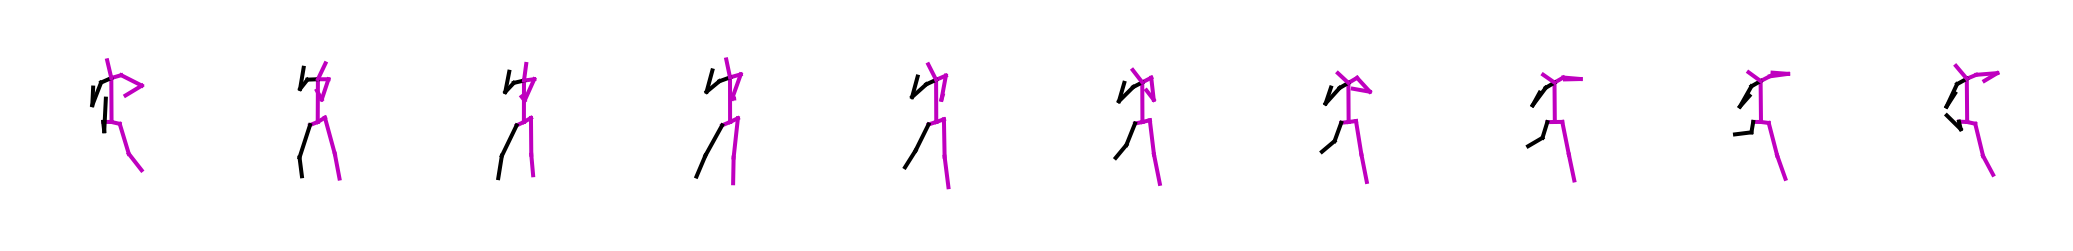

In [75]:
# fg = get_all_plots_images(gt_images_full[:15])
for i in range(10):
    print i
    fig = get_all_plots(pred_ops[i:i+10],az = -90)
    plt.savefig("./pose_grid/"+str(i)+".png",bbox_inches = 'tight',dpi=350);

print pred_ops.shape

In [17]:
# import matplotlib.pyplot as plt
# %matplotlib inline  

In [18]:
# plt.imshow(speed, cmap='hot', interpolation='nearest')
# plt.savefig("test.svg", format="svg")
# plt.show()

In [19]:
# a = np.argmax(speed)

# c  = np.unravel_index(a, speed.shape)

# print c

In [20]:
# for i in range(-4,5):
#     l = mean + i*std
#     l = np.reshape(l, (1,128))
#     x_pred = sess.run(pred_ops_ph,feed_dict={state_ph : l})
#     imgs = sk_utils.get_skeleton_images(x_pred[0], title_prefix='p')
#     writer = imageio.get_writer('./predictions/op_{}.mp4'.format(i), fps=30)
#     for j, im in enumerate(imgs):
#         writer.append_data(im)
#         if j % 10 == 0:
#             print 'done with %d frames' % j
#     writer.close()
    